the Karplus Strong algorithm is a simple digital feedback lop with an internal buffer of M samples. the buffer is filled with a set of initial values and the loop, when running, produces an arbitraryly long output signal. althought ekementary, the K-S loop can be used to synthesized interesting musical sounds.


In [4]:
def KS_1(x, N):
    #given the initial buffer x, produce a N-sampl3 output
    # by concatenating identical copies of buffer
    y = x
    while len(y)< N:
        #keep appending until we reach or exceed the required
        y = np.append(y,x)
    # trim the excess
    y = y[0:N+1]
    return y

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython

In [6]:
plt.rcParams["figure.figsize"]=(14,4)
# then since we are playing with audio we need to set
#internal clock of the system aka  the sampling rate
Fs = 16000 # 16KHz sampling rate


With this sampling rate, since the period of the generated signal is equal to the length of the inital buffer, we will be able to compute the fundamental frequency of the resulting sound. For instance, if we init the K-S algorithm with a vector of 50 values, the buffer will fit  16000/50=320 times in a second's worth of samples or, in other words, the resulting frequency will be 320Hz, which corresponds roughly to a E4 on a piano.

We still haven't talked about what to use as the initial values for the buffer. Well, the cool thing about K-S is that we can use pretty much anything we want; as a matter of fact, using random values will give you a totally fine sound. As a proof, consider this initial data set:

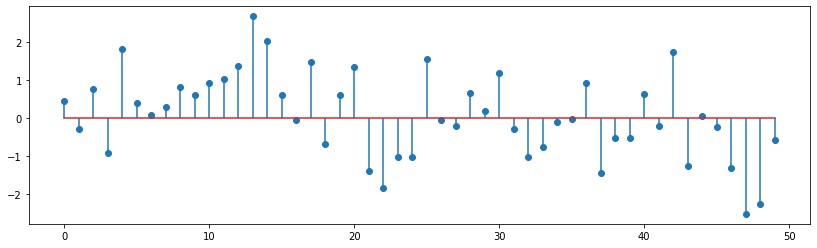

In [7]:
b = np.random.randn(50)
plt.stem(b, use_line_collection = True);

<StemContainer object of 3 artists>

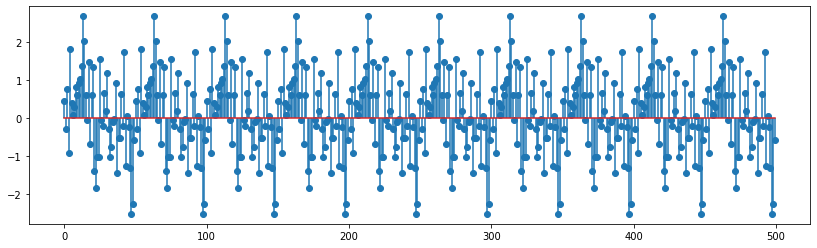

In [8]:
# lets generate a 2-second audio clip
y = KS_1(b, Fs*2)
# we can look at a few periods
plt.stem(y[0:500], use_line_collection = True)

In [9]:
IPython.display.Audio(y, rate=Fs)

In [10]:
# let's play an octave lower: just double the initial buffer's length
IPython.display.Audio(KS_1(np.random.rand(100), Fs * 2), rate=Fs)

Let's implement the K-S algorithm as a signal proessing loop

In [11]:
def KS_2(x, N):
    M = len(x)
    y = np.zeros(N)
    for n in range(0, N):
        y[n] = (x[n] if n<M else 0) + (y[n-M] if n-M>=0 else 0) 
    return y

In [12]:
# it should still work
IPython.display.Audio(KS_2(np.random.rand(50), Fs * 2), rate=Fs)

In [13]:
def KS_3(x, N, alpha = 0.99):
    M = len(x)
    y = np.zeros(N)
    # 
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + alpha * (y[n-M] if n-M >= 0 else 0)
    return y

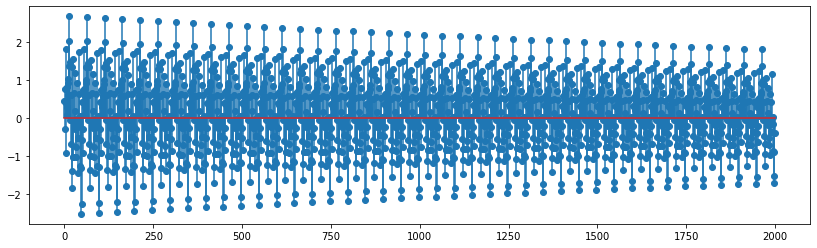

In [14]:
y = KS_3(b, Fs * 2)
plt.stem(y[0:2000], use_line_collection = True);

In [15]:
IPython.display.Audio(y, rate=Fs)

In [16]:
IPython.display.Audio(KS_3(np.random.rand(50), Fs * 2), rate=Fs)

In [17]:
IPython.display.Audio(KS_3(np.random.rand(10), Fs * 2), rate=Fs)

This is no good and therefore we need to compensate so that, if a is the same, the decay rate s the same. this lead us to last implemetation of the K-S algo

In [21]:
def KS(x, N, alpha = 0.99):
    #we will adjust alpha so that all notes have a decay
    # comparable to that of a buf len of 50 samples
    REF_LEN = 50
    M = len(x)
    a = alpha**(float(M)/REF_LEN)
    y = np.zeros(N)
    for n in range(0,N):
        y[n]= (x[n] if n<M else 0) + a*(y[n-M]if n-M>0 else 0)
    return y

In [22]:
IPython.display.Audio(KS(np.random.rand(50), Fs * 2), rate=Fs)

In [24]:
IPython.display.Audio(KS(np.random.rand(10), Fs * 2), rate=Fs)

In [25]:
def freq(note):
    #general purpose function to convert a not in standard notation
    # to corresponding frequency
    if len(note)<2 or len(note)>3 or \
    note[0]<'A' or note[0]>'G':
        return 0
    if len(note)==3:
        if note[1] =='b':
            acc =-1
        elif note[1]=='#':
            acc=1
        else: 
            return 0
        octave = int(note[2])
    else: 
        acc=0
        octave = int(note[1])
    SEMITONES = {'A': 0, 'B': 2, 'C': -9, 'D': -7, 'E': -5, 'F': -4, 'G': -2}
    n = 12*(octave -4)+SEMITONES[note[0]]+acc
    f = 440*(2**(float(n)/12.0))
    return f

def ks_chord(chord, N, alpha):
    y = np.zeros(N)
    # the chord is a dictionary: pitch => gain
    for note, gain in chord.items():
        # create an initial random-filled KS buffer the note
        x = np.random.randn(int(np.round(float(Fs) / freq(note))))
        y = y + gain * KS(x, N, alpha)
    return y  
             

In [26]:
# A Hard Day's Night's chord
hdn_chord = {
    'D2' : 2.2, 
    'D3' : 3.0, 
    'F3' : 1.0, 
    'G3' : 3.2, 
    'F4' : 1.0, 
    'A4' : 1.0, 
    'C5' : 1.0, 
    'G5' : 3.5,
}
    
IPython.display.Audio(ks_chord(hdn_chord, Fs * 4, 0.995), rate=Fs)